In [1]:
from spectacle.core.spectra import Spectrum1D
from spectacle.process.lsf import LSF
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from spectacle.modeling.fitting import LevMarFitter
from astropy.modeling.models import Linear1D
from spectacle.core.models import Voigt1D

from uncertainties import unumpy as unp

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 8]

# Identify and parameterize real data
This is an example notebook of taking some real data and fitting an absorption feature. It is very basic, and uses all the default settings.

## Load data
Load the data. The fitter currently assumes that all data has been normalized to 1.

In [3]:
# Load real data
hdulist = fits.open("/Users/nearl/projects/hst_proposal/QSOALS/3C066A/3C066A_coadd_FUVM_final_all.fits")
disp, flux, uncert, dq = hdulist[1].data['WAVE'], hdulist[1].data['FLUX'], \
                         hdulist[1].data['ERROR'], hdulist[1].data['DQ']


/Users/nearl/anaconda3/envs/spec_env/lib/python3.5/site-packages/spectacle/core/spectra.py:146: RuntimeWarning: divide by zero encountered in power
  self.flux) ** -3)
/Users/nearl/anaconda3/envs/spec_env/lib/python3.5/site-packages/astropy/modeling/fitting.py:325: RuntimeWarning: invalid value encountered in true_divide
  lacoef, resids, rank, sval = np.linalg.lstsq(lhs / scl, rhs, rcond)


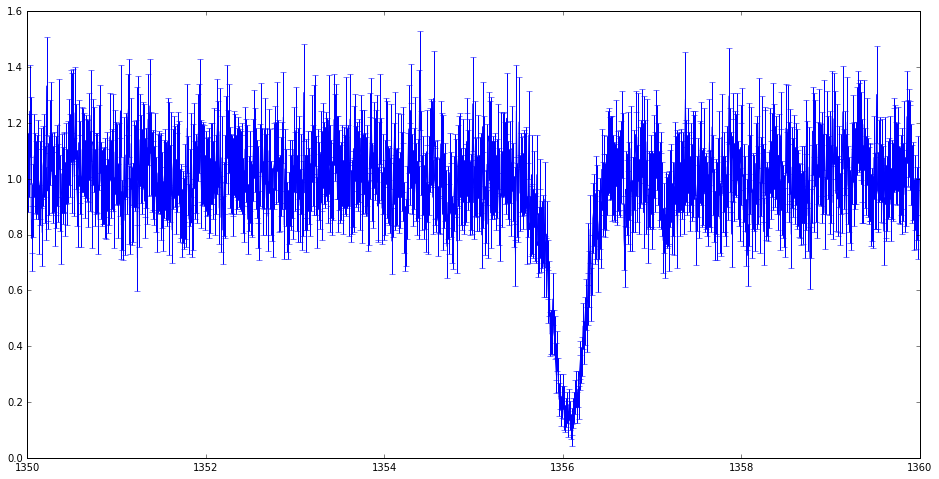

In [4]:
# Create a mask and apply it since we don't really care about the entire spectrum
mask = [(disp > 1350) & (disp < 1360)]

flux = flux[mask]
disp = disp[mask]
uncert = uncert[mask]

# Currently, the fitting assumes that the data is normalized to 1.0
tmp_flux = unp.uarray(flux, uncert)
tmp_flux /= np.median(tmp_flux)
flux, uncert = unp.nominal_values(tmp_flux), unp.std_devs(tmp_flux)

# Create spectrum object
spectrum = Spectrum1D(disp, flux, uncertainty=uncert)

# Plot the spectrum
plt.errorbar(spectrum.dispersion, spectrum.flux, yerr=spectrum.uncertainty)
# plt.plot(spectrum.dispersion, spectrum.flux)
plt.show()

## Create `Fitter`
The `Fitter` object encapsulates the method of fitting, along with the line identifying and detrending routines. Certain parameters, like the distance between identified lines, and the noise level can also be set.

Found 1 peaks
   Parameter     Original Value  Fitted Value Uncertainty
---------------- -------------- ------------- -----------
         slope_0            0.0           0.0         0.0
     intercept_0            1.0           1.0         0.0
      lambda_0_1  1356.10697068 1356.10697068         inf
       f_value_1            0.5           0.5         inf
         gamma_1         5560.0        5560.0         0.0
     v_doppler_1     10000000.0    10000000.0         inf
column_density_1          5e+13         5e+13         inf


/Users/nearl/anaconda3/envs/spec_env/lib/python3.5/site-packages/scipy/optimize/minpack.py:666: RuntimeWarning: divide by zero encountered in true_divide
  weights = 1.0 / asarray(sigma) if sigma is not None else None
/Users/nearl/anaconda3/envs/spec_env/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


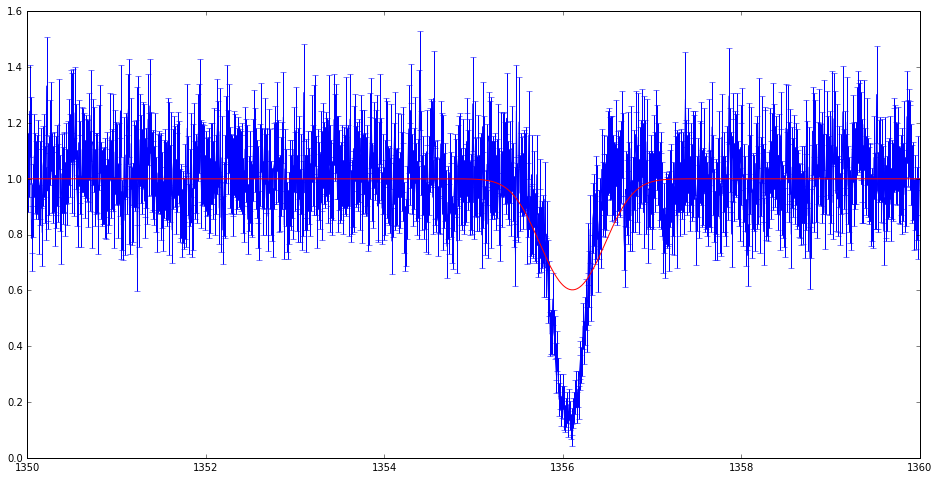

In [5]:
# Create a fitter. The default fitting routine is a LevMarLSQ.
fitter = LevMarFitter()
result_spectrum = fitter(spectrum)
print(fitter.fit_info)

# Plot the fitted spectrum with the original
plt.errorbar(spectrum.dispersion, spectrum.flux, yerr=spectrum.uncertainty)
plt.plot(result_spectrum.dispersion, result_spectrum.flux, color='red')

Let's get some first- and second-order information out of this.

In [6]:
print("Equivalent width: {}".format(result_spectrum.equivalent_width()))
print("FWHM: {}".format(result_spectrum.fwhm(1356)))
print("Optical Depth: {}".format(result_spectrum.optical_depth(1356)))
print("Centroid: {}".format(result_spectrum.centroid(1356)))

Equivalent width: (0.3430405804130044, 0.0)
FWHM: 11120.034196420656
Optical Depth: (array(0.4786960090349724), array(0.0))
Centroid: (array(1354.9615919748464), array(0.0))


In [7]:
print(result_spectrum.model)

Model: CompoundModel0
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Linear1D(slope=0.0, intercept=1.0)>

    [1]: <Voigt1D(lambda_0=1356.1069706827402, f_value=0.5, gamma=5560.0, v_doppler=10000000.0, column_density=50000000000000.0, name='')>
Parameters:
    slope_0 intercept_0   lambda_0_1  f_value_1 gamma_1 v_doppler_1 column_density_1
    ------- ----------- ------------- --------- ------- ----------- ----------------
        0.0         1.0 1356.10697068       0.5  5560.0  10000000.0            5e+13
